<a href="https://colab.research.google.com/github/BhargavaKanakapura/UGH_Coding_ABV_NorthAmerica/blob/main/FINAL_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import clear_output
from random import randint, choice, random

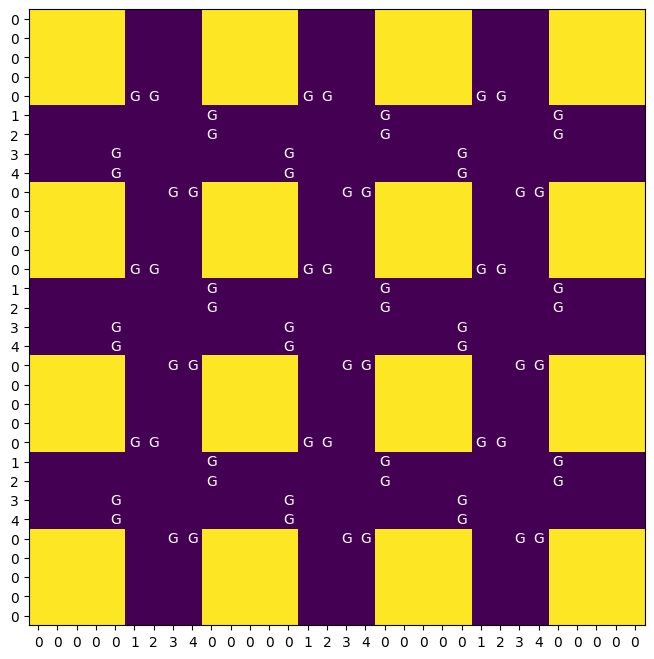

In [49]:
class RoadGrid():

    def __init__(self, numRoads, maxCars):

        self.numRoads = numRoads
        self.maxCars = maxCars
        self.lanes = 2
        self.N = self.numRoads * self.lanes * 2 + (self.numRoads + 1) * self.maxCars

        self.v_lanes = []
        for i in range(self.N):
            i = i % (self.maxCars + self.lanes * 2)
            if (i < self.maxCars): self.v_lanes.append(0)
            else: self.v_lanes.append(i - self.maxCars + 1)

        self.h_lanes = self.v_lanes

        self.grid = self.createMatrix(maxCars, self.lanes, numRoads)
        self.signal_grid = self.createSignalMatrix()

    def createMatrix(self, maxCars, lanes, roads):

        matrix = []
        N = roads * lanes * 2 + (roads + 1) * maxCars

        def createBlock():
            for _ in range(maxCars):
                row = []
                for _ in range(roads):
                    for _ in range(maxCars):
                        row.append("X")
                    for _ in range(lanes * 2):
                        row.append("O")
                for _ in range(maxCars):
                    row.append("X")
                matrix.append(row)


        for _ in range(roads):

            createBlock()

            for _ in range(lanes * 2):
                matrix.append(['O' for _ in range(self.N)])

        createBlock()

        return matrix

    def createSignalMatrix(self):

        signal_grid = [[['X', 'X'] for _ in range(self.N)] for _ in range(self.N)]

        for r in range(self.N - 1):
            for c in range(self.N - 1):

                if 1 == self.h_lanes[r + 1]:

                    if self.v_lanes[c] == 1:
                        signal_grid[r][c] = ["F", "G"]

                    elif self.v_lanes[c] == 2:
                        signal_grid[r][c] = ["LT", "G"]

                elif 4 == self.h_lanes[r - 1]:

                    if self.v_lanes[c] == 3:
                        signal_grid[r][c] = ["LT", "G"]

                    elif self.v_lanes[c] == 4:
                        signal_grid[r][c] = ["F", "G"]

        for r in range(self.N - 1):
            for c in range(self.N - 1):

                if 4 == self.v_lanes[c - 1]:

                    if self.h_lanes[r] == 1:
                        signal_grid[r][c] = ["F", "G"]

                    elif self.h_lanes[r] == 2:
                        signal_grid[r][c] = ["LT", "G"]

                elif 1 == self.v_lanes[c + 1]:

                    if self.h_lanes[r] == 3:
                        signal_grid[r][c] = ["LT", "G"]

                    elif self.h_lanes[r] == 4:
                        signal_grid[r][c] = ["F", "G"]

        return signal_grid

    def displayGrid(self):

        tokens = ["O", "C", "X"]
        augmentedGrid = [[tokens.index(s) for s in r] for r in self.grid]

        fig = plt.figure(figsize=(8,8))
        plt.imshow(augmentedGrid)
        plt.xticks(labels=self.v_lanes, ticks=range(0, self.N))
        plt.yticks(labels=self.h_lanes, ticks=range(0, self.N))

        for i in range(len(self.signal_grid)):
            for j in range(len(self.signal_grid[i])):
                if self.signal_grid[i][j] != ["X", "X"]:
                    text = plt.text(j, i, self.signal_grid[i][j][1],
                                    ha="center", va="center", color="w")

    def spawnCars(self, direction_cars):

        self.grid = self.createMatrix(self.maxCars, self.lanes, self.numRoads)

        for car in direction_cars["N"]:
            self.grid[car.row][car.col] = "C"

        for car in direction_cars["S"]:
            self.grid[car.row][car.col] = "C"

        for car in direction_cars["E"]:
            self.grid[car.row][car.col] = "C"

        for car in direction_cars["W"]:
            self.grid[car.row][car.col] = "C"

    def get(self, r, c):
        self.grid[r][c]

road = RoadGrid(3, 5)
road.displayGrid()
plt.draw()

In [50]:
direction_cars = {
    "N" : [],
    "S" : [],
    "E" : [],
    "W" : []
}

deadCars = []

def reset():
    direction_cars = {
        "N" : [],
        "S" : [],
        "E" : [],
        "W" : []
    }
    for i in range(len(deadCars) - 1, -1, -1):
        del deadCars[i]

def sortNorth():
    direction_cars["N"] = sorted(direction_cars["N"], key = lambda c: c.row * 2 + int(c.intention != "M"))

def sortSouth():
    direction_cars["S"] = sorted(direction_cars["S"], key = lambda c: 2 * c.row + int(c.intention == "M"))
    direction_cars["S"].reverse()

def sortEast():
    direction_cars["E"] = sorted(direction_cars["E"], key = lambda c: 2 * c.col + int(c.intention == "M"))
    direction_cars["E"].reverse()

def sortWest():
    direction_cars["W"] = sorted(direction_cars["W"], key = lambda c: c.col * 2 + int(c.intention != "M"))

In [51]:
class Car():

    def __init__(self, startRow, startCol):

        self.col = startCol
        self.row = startRow

        self.v_lane, self.h_lane = self.find_lane()

        self.intention = "F"
        # intention: F-Forward LT-Left Turn RT-Right Turn M-Merge
        self.moved = False

        self.deadTime = 0 #time a car spends not moving

        #dir: change_row, change_col

        if (self.v_lane == 0):
            if self.h_lane in [3, 4]:
                self.true_dir = "E"
                self.dir = [0, 1]
            else:
                self.true_dir = "W"
                self.dir = [0, -1]

        else:
            if self.v_lane in [3, 4]:
                self.true_dir = "N"
                self.dir = [-1, 0]
            else:
                self.true_dir = "S"
                self.dir = [1, 0]

        direction_cars[self.true_dir].append(self)

    def __eq__(self, o):
        return self.row == o.row and self.col == o.col

    def find_lane(self):
        return (road.v_lanes[self.col], road.h_lanes[self.row])

    def move(self):

        self.moved = False

        if self.intention == "F":
            self.dir, temp_true_dir = self.forward(j=road.signal_grid[self.row][self.col][0] == "F")

        elif self.intention == "LT":
            self.dir, temp_true_dir = self.turnLeft()

        elif self.intention == "RT":
            self.dir, temp_true_dir = self.turnRight()

        elif self.intention == "M":
            self.dir, temp_true_dir = self.merge()

        if self.nextSquareFree(self.dir) and road.signal_grid[self.row][self.col][1] != "R":

            p_row = self.row
            p_col = self.col
            self.row += self.dir[0]
            self.col += self.dir[1]
            road.grid[p_row][p_col], road.grid[self.row][self.col] = road.grid[self.row][self.col], road.grid[p_row][p_col]
            self.v_lane, self.h_lane = self.find_lane()

            if (self.true_dir != temp_true_dir):
                direction_cars[self.true_dir].remove(self)
                direction_cars[temp_true_dir].append(self)

            self.true_dir = temp_true_dir
            self.moved = True

        else:
            self.deadTime += 1

        self.makeNextIntention()

    def makeNextIntention(self):

        if road.signal_grid[self.row][self.col][0] == "LT":
            self.intention = "LT"

        elif road.signal_grid[self.row][self.col][0] == "F":
            self.intention = "RT" if randint(1, 4) == 1 else "F"

        else:
            self.intention = "M" if randint(1, 5) == 1 else "F"

    def nextSquareFree(self, dir):
        #Determine if the square the car will move inot is occupied
        #If it is at the edge destroy it

        if self.intention in ["F", "M"] and (self.row + self.dir[0] in [-1, road.N] or self.col + self.dir[1] in [-1, road.N]):
            self.destroy()
            return False

        if road.grid[self.row + dir[0]][self.col + dir[1]] == "O":
            return True
        else:
            return False

    def forward(self, j=False):
        # j is true if it needs to jump the intersection
        # Determine the vel vector of car to go forward

        if (self.true_dir == "N"):
            dir = [-1, 0]
        elif (self.true_dir == "S"):
            dir = [1, 0]
        elif (self.true_dir == "E"):
            dir = [0, 1]
        else:
            dir = [0, -1]
        return [dir, self.true_dir] if not(j) else [[dir[0] * (road.lanes * 2 + 1), dir[1] * (road.lanes * 2 + 1)], self.true_dir]

    def turnLeft(self):
        # Determine velocity vector to turn left

        if (self.true_dir == "N"):
            dir = [-3, -3]
            temp_new_true_dir = "W"
        elif (self.true_dir == "S"):
            dir = [3, 3]
            temp_new_true_dir = "E"
        elif (self.true_dir == "E"):
            dir = [-3, 3]
            temp_new_true_dir = "N"
        else:
            dir = [3, -3]
            temp_new_true_dir = "S"
        return [dir, temp_new_true_dir]

    def turnRight(self):
        # Determine vel vector to turn right

        if (self.true_dir == "N"):
            dir = [-1, 1]
            temp_new_true_dir = "E"
        elif (self.true_dir == "S"):
            dir = [1, -1]
            temp_new_true_dir = "W"
        elif (self.true_dir == "E"):
            dir = [1, 1]
            temp_new_true_dir = "S"
        else:
            dir = [-1, -1]
            temp_new_true_dir = "N"
        return [dir, temp_new_true_dir]

    def merge(self):

        currentLanes = self.find_lane()

        if (currentLanes[0] == 3 or currentLanes[0] == 2 or currentLanes[1] == 3 or currentLanes[1] == 2):
            if (self.true_dir == "N"):
                dir = [-1, 1]
            elif (self.true_dir == "S"):
                dir = [1, -1]
            elif (self.true_dir == "E"):
                dir = [1, 1]
            else:
                dir = [-1, -1]

        else:
            if (self.true_dir == "N"):
                dir = [-1, -1]
            elif (self.true_dir == "S"):
                dir = [1, 1]
            elif (self.true_dir == "E"):
                dir = [-1, 1]
            else:
                dir = [1, -1]

        return [dir, self.true_dir]

    def destroy(self):
        direction_cars[self.true_dir].remove(self)
        deadCars.append(self)
        return self.deadTime

    def __repr__(self):
        return f"{self.row}, {self.col}, {self.dir}"

In [52]:
class Intersection():

    def __init__(self, signals):
        self.signals = signals
        self.changeGroup(1)
        self.green = 1

    def switch(self):
        self.changeGroup(self.green % 4)
        self.green += 1
        self.changeGroup(self.green % 4)

    def changeGroup(self, i):
        for s in self.signals[i]:
            r, c = s
            if road.signal_grid[r][c][1] == "G":
                road.signal_grid[r][c][1] = "R"
            else:
                road.signal_grid[r][c][1] = "G"

ctr = 0
intersections = [[] for _ in range(road.numRoads ** 2)]
for r in range(road.N):
    for c in range(road.N):
        if list(set((road.h_lanes[r], road.v_lanes[c]))) == [2]:
            intersections[ctr] = [[(r-road.lanes, c-(road.lanes-1)), (r+(road.lanes+1), c+road.lanes)],
                                  [(r-road.lanes, c-(road.lanes-2)), (r+(road.lanes+1), c+road.lanes-1)],
                                  [(r+(road.lanes-1), c-road.lanes), (r+(road.lanes-2), c+road.lanes+1)],
                                  [(r+road.lanes, c-road.lanes), (r-(road.lanes-1), c+(road.lanes+1))]]
            ctr += 1

for i in range(len(intersections)):
    intersections[i] = Intersection(intersections[i])

In [53]:
cycleTimes = [randint(3, 7) for _ in intersections]

def update_all_signals(step):
    for i in range(len(cycleTimes)):
        if step % cycleTimes[i] == 0:
            intersections[i].switch()

def update_all_cars():
    # order each list
    # move each car
    # check if each car is deleted

    sortNorth()
    sortSouth()
    sortEast()
    sortWest()

    all_cars = direction_cars["N"] + direction_cars["S"] + direction_cars["W"] + direction_cars["E"]

    for c in all_cars:
        c.move()

log = []

def step_simulation(step):
    road.spawnCars(direction_cars)
    road.displayGrid()
    plt.draw()
    plt.pause(0.05)
    clear_output(wait=True)
    log.append(direction_cars.copy())
    update_all_cars()
    update_all_signals(step)

In [54]:
def simulate(numCars):

    reset()

    numCarsCurrent = 1
    allLocationsToSpawn = []

    for c in range(road.N):
        if road.v_lanes[c] in [1, 2]:
            allLocationsToSpawn.append([c, road.N - 1])
            allLocationsToSpawn.append([0, c])
        elif road.v_lanes[c] in [3, 4]:
            allLocationsToSpawn.append([road.N - 1, c])
            allLocationsToSpawn.append([c, 0])

    c1 = Car(*allLocationsToSpawn[5])
    step = 0

    while direction_cars["N"] != [] or direction_cars["S"] != [] or direction_cars["E"] != [] or direction_cars["W"] != []:
        step_simulation(step)
        if numCarsCurrent < numCars:
            l = choice(allLocationsToSpawn)
            if road.grid[l[0]][l[1]] == "O":
                Car(l[0], l[1])
                numCarsCurrent += 1
        step += 1

    step_simulation(step)

    sum = 0
    for c in deadCars:
        sum += c.deadTime

    return sum

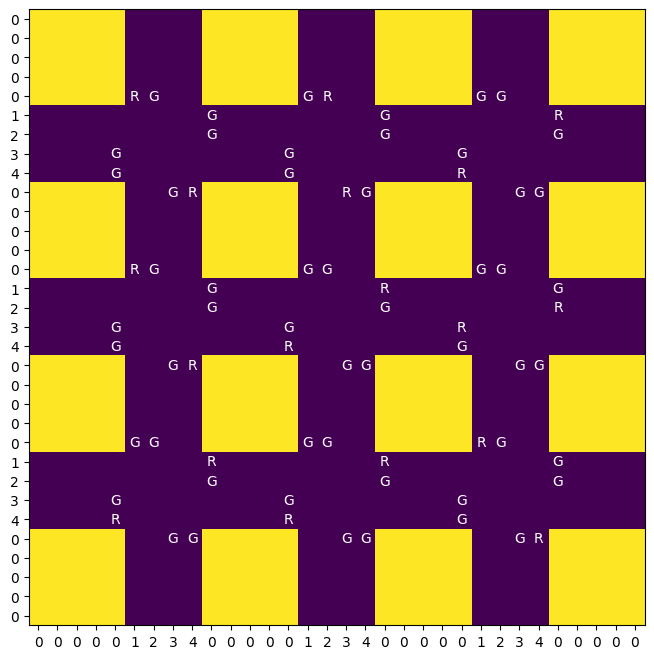

In [59]:
epochs = 5
L = 10000000000000 #minimum loss
L_log = []
for epoch in range(epochs):
    for i in range(len(cycleTimes)):
        epsilon = randint(-1, 2) #generate a random number between
        temp_cycleTimes = cycleTimes.copy()
        cycleTimes[i] = max(3, cycleTimes[i] + epsilon)
        newL = simulate(50)
        L_log.append(newL)
        if newL < L:
            L = newL
        else:
            cycleTimes = temp_cycleTimes.copy()

In [61]:
L, L_log

(141,
 [239,
  167,
  168,
  161,
  164,
  184,
  160,
  234,
  169,
  158,
  184,
  144,
  228,
  147,
  194,
  153,
  200,
  223,
  143,
  182,
  224,
  185,
  167,
  205,
  200,
  159,
  173,
  190,
  224,
  141,
  156,
  169,
  188,
  172,
  158,
  220,
  156,
  177,
  195,
  190,
  166,
  191,
  166,
  196,
  186])